In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print(f[0])

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
y = np.zeros((temp.shape[0], 11))
for jj in range(temp.shape[0]):
    y[jj, int(temp[jj,-1])] += 1
data['y'] = np.copy(y)
del y

print('input data x has shape: ',  data['x'].shape)
print('output data y has shape: ', data['y'].shape)
print()

if 0:
    jj = 6
    print(data['x'][jj,:])
    print(data['y'][jj,:])
    print(temp[jj,-1])

full_speach_data.ssv
input data x has shape:  (990, 10)
output data y has shape:  (990, 11)



In [4]:
# normalize data in the range [0,1]
for jj in range(data['x'].shape[1]):
    data['x'][:,jj] = (data['x'][:,jj]-min(data['x'][:,jj]))/max(data['x'][:,jj])

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'
nondefault = [45*11, 45*11]

setting = 0
if setting == 0:
    train['x'] = np.copy(data['x'][:default[0],:])
    train['y'] = np.copy(data['y'][:default[0],:])
    
    test['x']  = np.copy(data['x'][-default[1]:,:])
    test['y']  = np.copy(data['y'][-default[1]:,:])
#elif setting == 1:
#    train['x'] = np.copy(data['x'][:nondefault[0],:])
#    train['y'] = np.copy(data['y'][:nondefault[0],:])
#    
#    test['x']  = np.copy(data['x'][-nondefault[1]:,:])
#    test['y']  = np.copy(data['y'][-nondefault[1]:,:])
    
print(train['x'].shape)
print(train['y'].shape)
print()
print(test['x'].shape)
print(test['y'].shape)

(528, 10)
(528, 11)

(462, 10)
(462, 11)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
y = Variable( torch.from_numpy(train['y']).float() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
y_test = Variable( torch.from_numpy(test['y']).float() )

In [7]:
# define settings for plots
def show_graph(string):
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    if string=='loglog':
        for ii, ee in err.items():
            ax1.loglog(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    elif string=='logy':
        for ii, ee in err.items():
            ax1.semilogy(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    elif string=='logx':
        for ii, ee in err.items():
            ax1.semilogy(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))
    else:
        for ii, ee in err.items():
            ax1.plot(ee[2][:], label='error %s, lr=%1.0e'%(ee[0],ee[1]))

    ax1.set_xlabel('iteration number', fontsize = 16)
    ax1.set_ylabel('loss', fontsize = 16)
    title_string = '%d epochs, batch size %d; [%d, %d, %d] are input, hidden, and output dimensions'%(epochs,N,D_in,H,D_out)
    ax1.set_title(title_string, fontsize = 16)
    legend = ax1.legend(loc='best', fontsize=16)

    plt.show()
    plt.close()

# prints errors in semi-log axis
show_type = 'logy'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N     = train['x'].shape[0]
D_in  = train['x'].shape[1]
H     = 64
D_out = train['y'].shape[1]

epochs = int(5e2)

In [9]:
# model settings
base_lr = 1e-4
sigm_lr = 1e-6
best_lr = 1.5e-5

# (re-)initialize data dictionary
#mdl = [] # as in model
err = {} # as in error

In [10]:
# define baseline network with relu (clamp)
class Baseline(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Baseline, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        # sum (linear1) and then relu (clamp)
        h1     = self.linear1(x).clamp(min=0)
        # sum (linear2) and then relu (clamp)
        h2     = self.linear2(h1).clamp(min=0)
        # sum (out) and the output
        y_pred = self.linearOut(h2)
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
basemodel = Baseline(D_in, H, D_out)

# initialize dictionary item
err[0] = ('relu',base_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(basemodel.parameters(), lr=err[0][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = basemodel(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[0][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

25 444.2655334472656
50 426.4053039550781
75 414.9172058105469
100 405.90618896484375
125 398.4095764160156
150 391.7622375488281
175 385.704833984375
200 379.87200927734375
225 374.1127624511719
250 368.4815979003906
275 364.079833984375
300 361.0576171875
325 352.1493225097656
350 346.76068115234375
375 340.5955810546875
400 333.7928771972656
425 327.82269287109375
450 322.71807861328125
475 316.81500244140625
500 310.2469787597656


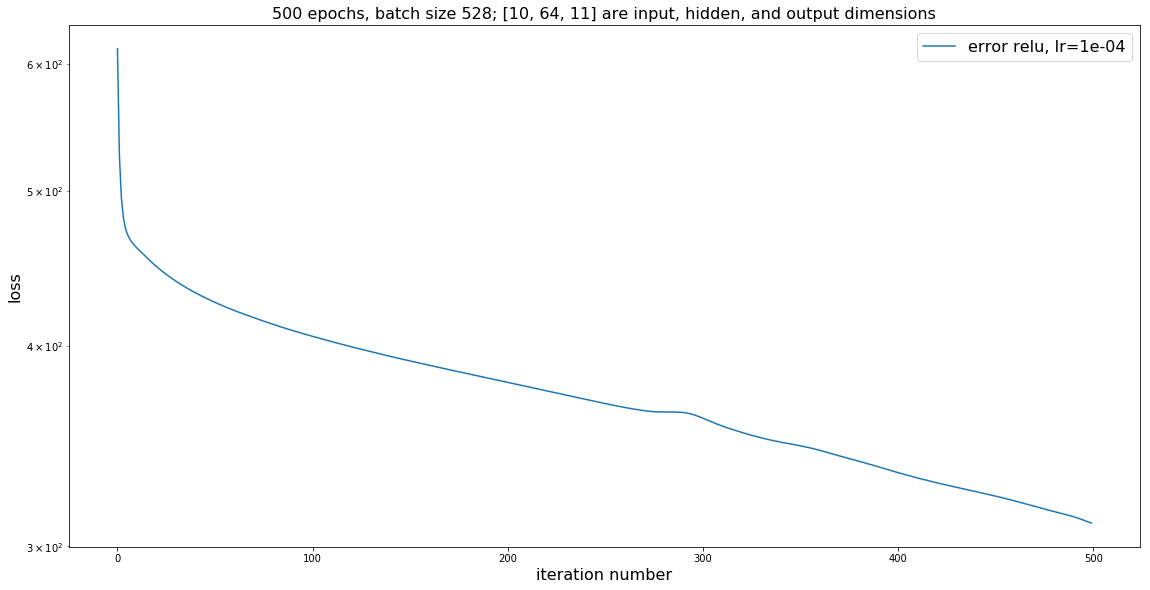

In [11]:
show_graph(show_type)

In [12]:
# testing results
correctness = 0
y_pred = basemodel(x_test)
for jj in range(x_test.shape[0]):
    if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
        correctness += 1
correctness = correctness/x_test.shape[0]*100
print(correctness)

48.268398268398265


In [13]:
# define baseline network with relu (clamp)
class Baseline2(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Baseline2, self).__init__()
        self.linear = torch.nn.Linear(D_in, H)
        self.inner =  torch.nn.Linear(H, H) 
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        
        h = []
        # sum (linear1) and then relu (clamp)
        h.append( self.linear[0](x).clamp(min=0) )
        # sum (linear2) and then relu (clamp)
        for jj in range(n):
            h.append( self.inner(h[jj]).clamp(min=0) )
        # sum (out) and the output
        if not NL_out:
            y_pred = self.linearOut(h[-1])
        elif NL_out:
            y_pred = self.linearOut(h[-1]).clamp(min=0)
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
        
        return y_pred # output = y_pred(icted)

# Construct our model by instantiating the class defined above
basemodel2 = Baseline2(D_in, H, D_out)

# initialize dictionary item
err[1] = ('relu2',base_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(basemodel2.parameters(), lr=err[1][1])

for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = basemodel2(x, 1, False)

    # Compute and print loss
    loss = criterion(y_pred, y)
    err[1][2].append(loss.data[0])
    if (t+1)%(epochs//20) == 0:
        print(t+1, loss.data[0])

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
del criterion, optimizer

TypeError: __init__() takes 4 positional arguments but 5 were given

In [ ]:
show_graph(show_type)

In [ ]:
# testing results
correctness = 0
y_pred = basemodel2(x_test)
for jj in range(x_test.shape[0]):
    if y_test.data[jj, np.argmax(y_pred.data[jj,:]) ]:
        correctness += 1
correctness = correctness/x_test.shape[0]*100
print(correctness)

In [ ]:
print(basemodel)
print(basemodel2)

In [ ]:
for idx, m in enumerate(basemodel.modules()):
     print(idx, '->', m)
print()
for idx, m in enumerate(basemodel2.modules()):
     print(idx, '->', m)

In [14]:
# define baseline network with relu (clamp)
class Baseline3(torch.nn.Module):
    def __init__(self, D_in, H, D_out, n):
        super(Baseline3, self).__init__()
        self.linear0 = torch.nn.Linear(D_in, H)
        for jj in range(n):
            exec("self.linear%d = torch.nn.Linear(H, H)" %(jj+1) );
        self.linearOut = torch.nn.Linear(H, D_out)

    def forward(self, x, n, NL_out=False):
        
        h = []
        # sum (linear1) and then relu (clamp)
        h.append( self.linear0(x).clamp(min=0) )
        # sum (linear2) and then relu (clamp)
        for jj in range(n):
            exec("h.append( self.linear%d(h[jj]).clamp(min=0) )" %(jj+1) );
        # sum (out) and the output
        if not NL_out:
            y_pred = self.linearOut(h[-1])
        elif NL_out:
            y_pred = self.linearOut(h[-1]).clamp(min=0)
        else:
            raise ValueError('NL_out must be either True or False, but it isn\'t')
        
        return y_pred # output = y_pred(icted)

In [15]:
# Construct our model by instantiating the class defined above
basemodel3 = Baseline3(D_in, H, D_out, 2)

# initialize dictionary item
err[2] = ('relu2',base_lr,[])

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
criterion = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.SGD(basemodel3.parameters(), lr=err[2][1])

In [17]:
for idx, m in enumerate(basemodel3.modules()):
     print(idx, '->', m)

0 -> Baseline3(
  (linear0): Linear(in_features=10, out_features=64)
  (linear1): Linear(in_features=64, out_features=64)
  (linear2): Linear(in_features=64, out_features=64)
  (linearOut): Linear(in_features=64, out_features=11)
)
1 -> Linear(in_features=10, out_features=64)
2 -> Linear(in_features=64, out_features=64)
3 -> Linear(in_features=64, out_features=64)
4 -> Linear(in_features=64, out_features=11)
